# Frizione dinamica con [Rebound](https://rebound.readthedocs.io/en/latest/)

### Indice
1) Intro teorica frizione dinamica (da test-luca quasi scritto tutto)
2) Test per funzionamento base di rebound
    - Basic: aggiungere particelle con certa posizione e velocità 
    - Come usare il widget per la visualizzazione
    - Esempi: [cometa CG](https://rebound.readthedocs.io/en/latest/ipython_examples/Churyumov-Gerasimenko/), [self-gravitating disc](https://rebound.readthedocs.io/en/latest/c_examples/selfgravity_disc/)
3) Ricerca di un buon setup per studiare DF:
    - Box periodica con gas di particelle (destinate a collassare), poi aggiunto BH con determinata velocità: ma condizioni al contorno introducono effetti spuri
    - Tubo lungo dove il BH non fa in tempo a incontrare i muri
    - Idea vincente: galleria del vento
4) Ottimizzazione del setup: stelle continuamente sostituite da stelle immesse da destra, con un tasso controllato
5) Variazione dei parametri: mBH, v stelle (costante, MB), $\rho$ stelle, mantenendo log $\Lambda$ costante
6) Analisi degli integatori: su setup semplice (gas in box periodica, senza BH) variamo configurazione integratori, tree, softening, opening angle, teniamo parametri uguali ma numero di particelle variabile

In [1]:
# Importiamo tutti i pacchetti necessari
import numpy as np 
import matplotlib.pyplot as plt
import rebound  
import datetime

from PIL import Image
%matplotlib widget

### 1) Intro teorica frizione dinamica

When an object of mass MS (“subject mass”) moves through a large collisionless system whose contituent particles (“field particles”) have mass $m \ll M_s$, it experiences a drag force, called dynamical friction. Essa tramuta l'energia cinetica di $M_s$ in energia cinetica randomica delle $m$. Così facendo guida l'evoluzione orbitale non solo di galassie satellite, ma anche di buchi neri, ammassi globulari vicini ai centri galattici e le barre di spirali barrate. 

\
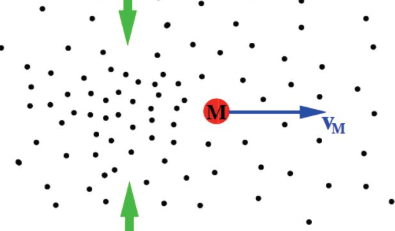


Nel caso di masse puntiformi, autogravità del campo di particelle trascurabile e se le particelle hanno una distribuzione di velocità isotropa (infinite homogeneous background), \
la forza di attrito dinamica a cui è soggetto il corpo $M_s$ è data dalla **Formula di Chandrasekhar**
$$ \vec{F}_\mathrm{df} = M_s \frac{d\vec{v}_s}{dt} = -4 \pi \bigg(\frac{G M_s}{v_s} \bigg)^2 \ln(\Lambda) \rho(<v_s) \frac{\vec{v}_s}{v_s}   $$  


$$\Lambda \approx \frac{b_\mathrm{max}}{b_\mathrm{90}} \quad\quad b_\mathrm{max} \sim R  \quad\quad  b_\mathrm{90} \sim \frac{G M_s}{v_\mathrm{rms}}$$


A differenza dell'attrito idrodinamico se $M_s$ è lento $F_\mathrm{df} \propto v_s$, se $M_s$ è veloce $F_\mathrm{df} \propto v_s^{-2}$. \
In più $F_\mathrm{df} \propto M_s^2$ per il doppio effetto sul wake.

### 2) Test per funzionamento base di rebound

- Cometa 67P/Churyumov–Gerasimenko

In [2]:
# per visualizzare nel server  http://localhost:1234
sim = rebound.Simulation()
sim.start_server(port=5555)
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("NAME = Churyumov-Gerasimenko; CAP", m =5.03e-18)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'NAME = Churyumov-Gerasimenko; CAP'... 
Found: 67P/Churyumov-Gerasimenko 


In [3]:
sim.status(showAllFields=False)
for orbit in sim.orbits():
    print(orbit)

---------------------------------
REBOUND version:     	4.4.2
REBOUND built on:    	Jul 15 2024 18:47:33
Number of particles: 	4
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x20fc44731d0, m=0.9999999999950272 x=-0.004799006953486278 y=-0.005283029142048807 z=0.0001637197690470164 vx=0.0004218267421603285 vy=-0.00013005550551229924 vz=-7.33587547971203e-06>
<rebound.particle.Particle object at 0x20fc44726d0, m=0.0009547919099366768 x=0.07735331421186827 y=5.12038977258681 z=-0.022966155720012423 vx=-0.4436953018322307 vy=0.027515683022640836 vz=0.009814126476596787>
<rebound.particle.Particle object at 0x20fc44731d0, m=0.0002858856700231729 x=9.5212949389664 y=-1.0623933018267162 z=-0.3606201320410973 vx=0.017983406851230385 vy=0.32162896966126747 vz=-0.00630909741692725>
<rebound.particle.Particle object at 0x20fc44726d0, m=5.03e-18 x=-2.5643226892275965 y=

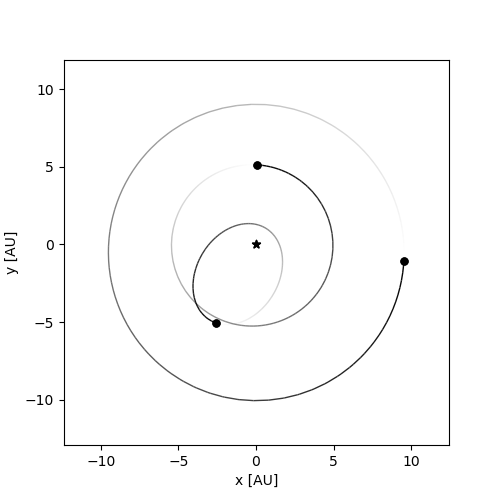

In [4]:
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

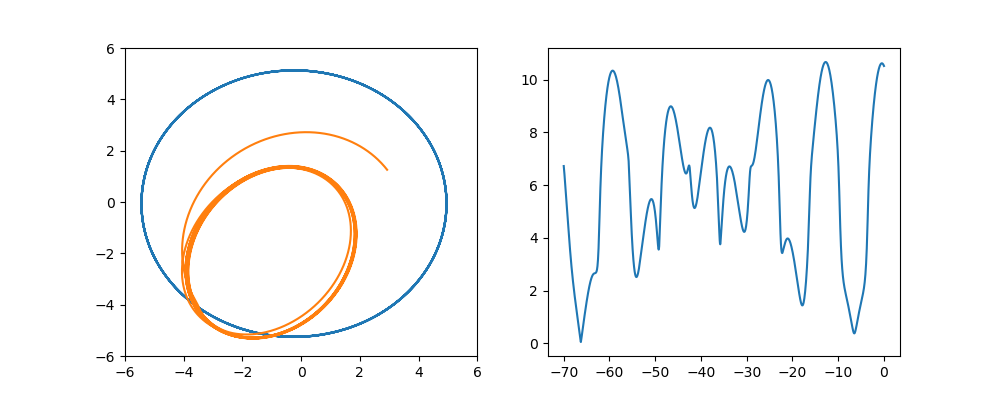

Minimum distance (0.048691 AU) occured at time: -66.254625 years.


'1959-02-06 00:53'

In [5]:
sim.dt = -0.01

Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-70.*year, Noutputs)
x = np.zeros((2,Noutputs))
y = np.zeros((2,Noutputs))
z = np.zeros((2,Noutputs))

sim.integrator = "ias15" # IAS15 is the default integrator, so we actually don't need this line
sim.move_to_com()        # We always move to the center of momentum frame before an integration
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

for i,time in enumerate(times):
    sim.integrate(time)
    x[0][i] = ps[1].x   # This stores the data which allows us to plot it later
    y[0][i] = ps[1].y
    z[0][i] = ps[1].z
    x[1][i] = ps[3].x
    y[1][i] = ps[3].y
    z[1][i] = ps[3].z

# Calcolo la loro distanza nel tmepo
distance = np.sqrt(np.square(x[0]-x[1])+np.square(y[0]-y[1])+np.square(z[0]-z[1]))
closeencountertime = times[np.argmin(distance)]/year

s = 6

fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,4))
ax.set_xlim([-s,s])
ax.set_ylim([-s,s])
ax.plot(x[0], y[0])
ax.plot(x[1], y[1])
ax2.plot(times/year, distance);
plt.show()

print("Minimum distance (%f AU) occured at time: %f years." % (np.min(distance),closeencountertime))
encounterdate = datetime.datetime.today() + datetime.timedelta(days=365.25*closeencountertime)
encounterdate.strftime("%Y-%m-%d %H:%M")

If you check Wikipedia or JPL, the encounter happened on 1959-Feb-04 06:24, so we are not far off (it turns out that's because of jets and other non-gravitational forces from the comet!)

https://en.wikipedia.org/wiki/67P/Churyumov%E2%80%93Gerasimenko

https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=67P;old%3D0;orb%3D0;cov%3D0;log%3D0;cad%3D1


- Self-gravitating disc

In [ ]:
sim = rebound.Simulation()
sim.start_server(port=3333) 
sim.widget(size=(600,600))

sim.integrator = "leapfrog"
sim.gravity = "tree"
sim.boundary = "open"

sim.opening_angle2 = 1.5 #  This constant determines the accuracy of the tree code grhavity estimate.
sim.softening = 0.2 # Gravitational softening length
sim.dt = 1e-2
sim.G = 1

size = 20
sim.configure_box(size) # creo box di lato size

sim.add(m=1.)           # aggiungo buco nero al centro
disc_mass = 2e-1        # masssa totale disco
N = 1000                # numero di stelle
      
rMin = 0.2*size/2       # raggio interno
rMax = 0.7*size/2       # raggio esterno

np.random.seed(0)       # per riproducibilità

for i in range(N):      # aggiungo una stella alla volta in orbita circolare
    
    # genero phi in [0,2pi] uniforme e semiasse maggiore in [rmin,rmax] da una distribuz con param q
    q = -3/2             
    a = rMax*((rMin/rMax)**(1/q)-1)**q*(np.random.rand(1)+((rMin/rMax)**(1/q)-1)**-1)**q # q diverso da 0 e 1
    phi = np.random.rand(1)*2*np.pi
    # calcolo la massa interna al luogo in cui posiziono la stella
    mu = sim.particles[0].m + disc_mass*(a**-3/2-rMin**-3/2)/(rMax**-3/2-rMin**-3/2)
    v_kep = np.sqrt(sim.G*mu/a)
    sim.add(m=disc_mass/N,x=a*np.cos(phi),y=a*np.sin(phi),z=a*np.random.rand(1)*0.001,vx=v_kep*np.sin(phi),vy=-v_kep*np.cos(phi),vz=0)


In [10]:
# evolvo il sistema
sim.integrate(200)

### 3) Ricerca di un buon setup per studiare DF

### 4) Ottimizzazione del setup

### 5) Variazione dei parametri

### 6) Analisi degli integratori

Vediamo di fare un setup semplice, gas in box periodiche (+ non periodiche?) e di vedere come cambia 



---
# Backstage

Test per capire come funzionano i collegamenti ipertestuali tra le sezioni.

Premendo [2)](#sezione2) si arriva alla sezione qui sotto

<a id='sezione2'></a>
### Sezione 2 